In [1]:
!nvidia-smi

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Sat Apr  1 21:17:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0  On |                  N/A |
|  0%   50C    P8    42W / 420W |    508MiB / 24576MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

In [2]:
%load_ext tensorboard

In [4]:
%tensorboard --logdir './Tensorflow/workspace/mymodel/train/'

In [30]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [31]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('./Tensorflow/workspace/coco/Script/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('./Tensorflow/workspace/mymodel/ckpt-3').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [32]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
category_index = label_map_util.create_category_index_from_labelmap('./Tensorflow/workspace/annotations/label_map.pbtxt')

In [34]:
IMAGE_PATH = './Tensorflow/workspace/images/test/6538771b-IMG_2726.JPG'

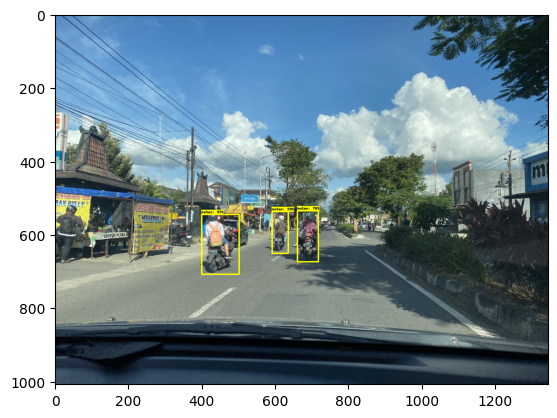

In [35]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)


num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections


# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


label_id_offset = 1
image_np_with_detections = image_np.copy()

counting_result = viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=15,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

<h4>4.a Freez The Model </h4>

In [3]:
FREEZE_SCRIPT = os.path.join('Tensorflow/models/research/object_detection', 'exporter_main_v2.py ')


In [14]:
!mkdir -p './Tensorflow/workspace/mymodel/export'

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [4]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,'./Tensorflow/workspace/coco/Script/pipeline.config', './Tensorflow/workspace/mymodel', './Tensorflow/workspace/mymodel/export')

In [5]:
print(command)

python Tensorflow/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=./Tensorflow/workspace/coco/Script/pipeline.config --trained_checkpoint_dir=./Tensorflow/workspace/mymodel --output_directory=./Tensorflow/workspace/mymodel/export


In [6]:
!{command}

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
2023-03-17 02:02:16.261306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:02:16.264415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:02:16.264494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the miss

<h4> 4. Create TFlite from Object Detection API for Future Project </h4>

In [9]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

In [8]:
!mkdir -p './Tensorflow/workspace/Tflite'
TFLITE_SCRIPT = os.path.join('Tensorflow/models/research/object_detection', 'export_tflite_graph_tf2.py ')

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [9]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,'./Tensorflow/workspace/coco/Script/pipeline.config','./Tensorflow/workspace/mymodel', './Tensorflow/workspace/Tflite')

In [10]:
!{command}

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
2023-03-17 02:11:51.397566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:11:51.404749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:11:51.404909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the miss

In [7]:
_TFLITE_MODEL_PATH = "Tensorflow/workspace/Tflite/saved_model/model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('Tensorflow/workspace/Tflite/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(_TFLITE_MODEL_PATH, 'wb') as f:
  f.write(tflite_model)

2023-03-22 01:48:59.114488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 01:48:59.160226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 01:48:59.161303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 01:48:59.170696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 01:48:59.171814: I tensorflow/compile

<h2> Notice !!! </h2>

<h3>Add Metadata </h3>
 The model needs to be packed with TFLite Metadata to enable easy integration into mobile apps such Android or IOS using the TFLite Task Library. 

In [12]:
_ODT_LABEL_MAP_PATH = 'Tensorflow/workspace/annotations/label_map.pbtxt'
_TFLITE_LABEL_PATH = "Tensorflow/workspace/Tflite/saved_model/tflite_label_map.txt"

category_index = label_map_util.create_category_index_from_labelmap(
    _ODT_LABEL_MAP_PATH)
f = open(_TFLITE_LABEL_PATH, 'w')
for class_id in range(1, 5):
  if class_id not in category_index:
    f.write('???\n')
    continue
  name = category_index[class_id]['name']
  f.write(name+'\n')
f.close()

<h2> Notice !!! </h2>

<h3> Normaliz config </h3>
Then we'll add the label map and other necessary metadata (e.g. normalization config) to the TFLite model. <br>
As the SSD MobileNet V2 FPNLite 640x640 model take input image with pixel value in the range of [-1..1] (code), we need to set norm_mean = 127.5 and norm_std = 127.5 <br>
you need to install tflite_support

```sh
pip install tflite_support 
```

In [14]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

_TFLITE_MODEL_WITH_METADATA_PATH = "Tensorflow/workspace/Tflite/saved_model/model_with_metadata.tflite"

writer = object_detector.MetadataWriter.create_for_inference(
    writer_utils.load_file(_TFLITE_MODEL_PATH), input_norm_mean=[127.5], 
    input_norm_std=[127.5], label_file_paths=[_TFLITE_LABEL_PATH])
writer_utils.save_file(writer.populate(), _TFLITE_MODEL_WITH_METADATA_PATH)

<h4> Read Metadata from tflite that have been created. <h4>


In [23]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file(_TFLITE_MODEL_WITH_METADATA_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("=============================")
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

Metadata populated:
{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
    

<h4> Future Project : Counting Object with Tensorflow Lite file </h4>

Implementation counting an object when Detecting Object on Single Images

In [2]:
import cv2
import numpy as np
from object_detection.utils import label_map_util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib.pyplot as plt

%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap('./Tensorflow/workspace/annotations/label_map.pbtxt')
### Define function for inferencing with TFLite model and displaying results

def tflite_detect_single_images(modelpath,lblpath, min_conf=0.5):

  # dir images
  images = './Tensorflow/workspace/images/test/06f6c63b-IMG_2742.JPG'

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Load image and resize to expected shape [1xHxWx3]
  image = cv2.imread(images)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imH, imW, _ = image.shape 
  image_resized = cv2.resize(image_rgb, (width, height))
  input_data = np.expand_dims(image_resized, axis=0)

        # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
  if float_input:
    input_data = (np.float32(input_data) - input_mean) / input_std

        # Perform the actual detection by running the model with the image as input
  interpreter.set_tensor(input_details[0]['index'],input_data)
  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
  classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
  scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

  detections = []
  object_count = []


    # Loop over all detections and draw detection box if confidence is above minimum threshold
  for i in range(len(scores)):
        if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'motor: 90%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window

            object_count.append(object_name)
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

            detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])
            
  counts = {}

# Iterate over the values in the list
  for val in object_count:
    # If the value is already in the dictionary, increment its count
    if val in counts:
        counts[val] += 1
    # Otherwise, add it to the dictionary with a count of 1
    else:
        counts[val] = 1

# Print the counts
  y_axis = 40 #set y_axis for putText
  for val, count in counts.items():
      cv2.putText(image,'Class: '+str(val) + ' appear '+ str(count),(30,y_axis),cv2.FONT_HERSHEY_SIMPLEX,1,(98,250,184),2,cv2.LINE_AA) 
      y_axis = y_axis + 40 #for each class that have been detected putText on y_axis must change so count display not overlapping for each class

  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(12,16))
  plt.imshow(image)
  plt.show()
        



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


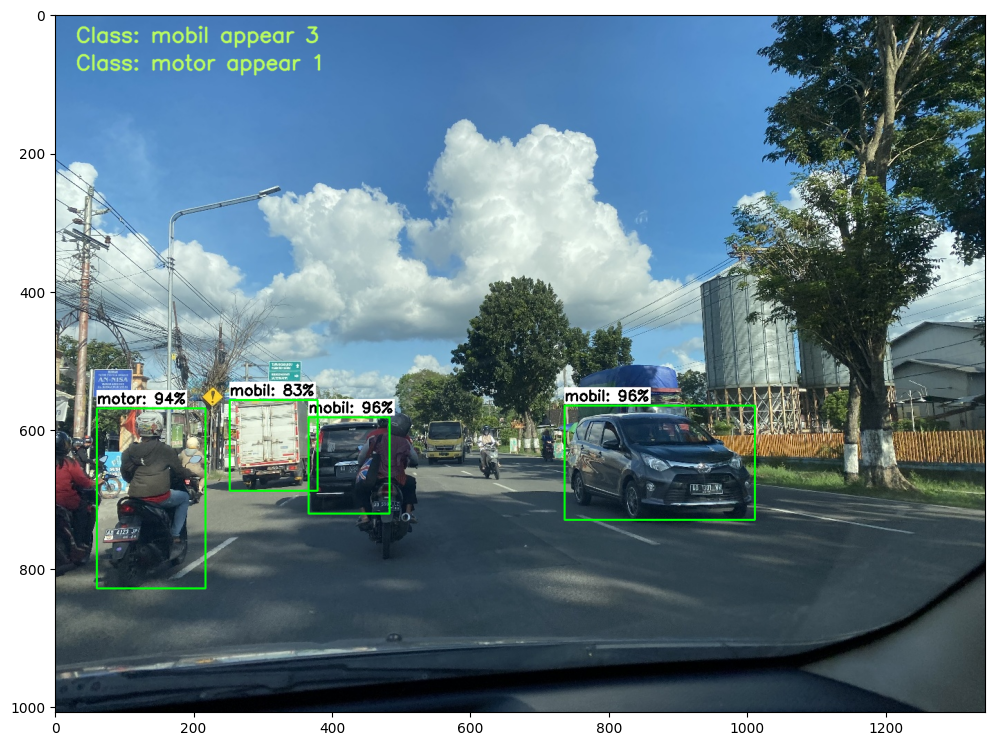

In [3]:
tflite_detect_single_images('./Tensorflow/workspace/Tflite/saved_model/model_with_metadata.tflite','./Tensorflow/workspace/Tflite/saved_model/tflite_label_map.txt', min_conf=0.8)

In [269]:
import os
import argparse
import importlib.util



# Define and parse input arguments
parser = argparse.ArgumentParser()

parser.add_argument('--labels', help='Name of the labelmap file, if different than labelmap.txt',
                    default='labelmap.txt')
parser.add_argument('--threshold', help='Minimum confidence threshold for displaying detected objects',
                    default=0.5)
parser.add_argument('--video', help='Name of the video file',
                    default='test.mp4')
parser.add_argument('--edgetpu', help='Use Coral Edge TPU Accelerator to speed up detection',
                    action='store_true')

args = parser.parse_args()

MODEL_NAME = './Tensorflow/workspace/Tflite/saved_model/'
GRAPH_NAME = 'model_with_metadata.tflite'
LABELMAP_NAME = './Tensorflow/workspace/Tflite/saved_model/tflite_label_map.txt'
VIDEO_NAME = args.video
min_conf_threshold = float(args.threshold)
use_TPU = args.edgetpu

# Import TensorFlow libraries
# If tflite_runtime is installed, import interpreter from tflite_runtime, else import from regular tensorflow
# If using Coral Edge TPU, import the load_delegate library
pkg = importlib.util.find_spec('tflite_runtime')
if pkg:
    from tflite_runtime.interpreter import Interpreter
    if use_TPU:
        from tflite_runtime.interpreter import load_delegate
else:
    from tensorflow.lite.python.interpreter import Interpreter
    if use_TPU:
        from tensorflow.lite.python.interpreter import load_delegate

# If using Edge TPU, assign filename for Edge TPU model
if use_TPU:
    # If user has specified the name of the .tflite file, use that name, otherwise use default 'edgetpu.tflite'
    if (GRAPH_NAME == 'detect.tflite'):
        GRAPH_NAME = 'edgetpu.tflite'   

# Get path to current working directory
CWD_PATH = os.getcwd()

# Path to video file
VIDEO_PATH = os.path.join(CWD_PATH,VIDEO_NAME)

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,GRAPH_NAME)

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_NAME,LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.
if labels[0] == '???':
    del(labels[0])

# Load the Tensorflow Lite model.
# If using Edge TPU, use special load_delegate argument
if use_TPU:
    interpreter = Interpreter(model_path=PATH_TO_CKPT,
                              experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
    print(PATH_TO_CKPT)
else:
    interpreter = Interpreter(model_path=PATH_TO_CKPT)

interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

# Check output layer name to determine if this model was created with TF2 or TF1,
# because outputs are ordered differently for TF2 and TF1 models
outname = output_details[0]['name']

if ('StatefulPartitionedCall' in outname): # This is a TF2 model
    boxes_idx, classes_idx, scores_idx = 1, 3, 0
else: # This is a TF1 model
    boxes_idx, classes_idx, scores_idx = 0, 1, 2

# Open video file
video = cv2.VideoCapture(VIDEO_PATH)
imW = video.get(cv2.CAP_PROP_FRAME_WIDTH)
imH = video.get(cv2.CAP_PROP_FRAME_HEIGHT)

while(video.isOpened()):

    # Acquire frame and resize to expected shape [1xHxWx3]
    ret, frame = video.read()
    if not ret:
      print('Reached the end of the video!')
      break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'],input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), (10, 255, 0), 4)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the frame, so it's time to display it.
    cv2.imshow('Object detector', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

# Clean up
video.release()
cv2.destroyAllWindows()

usage: ipykernel_launcher.py [-h] [--labels LABELS] [--threshold THRESHOLD]
                             [--video VIDEO] [--edgetpu]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/dimask/.local/share/jupyter/runtime/kernel-dd830c16-f4fc-4b47-b2f8-e70947629437.json


SystemExit: 2

/home/dimask/miniconda3/envs/tfod3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import cv2

# Open the video file
cap = cv2.VideoCapture('./Tensorflow/workspace/viewtest.mp4')

# Loop over the frames of the video
while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()
    # If there are no more frames, break out of the loop
    if not ret:
        break
    # Display the frame
    cv2.imshow('Video', frame)
    # Wait for a key press
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
cap.release()
cv2.destroyAllWindows()


: 

: 

In [5]:
import cv2

# Open the default camera
cap = cv2.VideoCapture(1)

# Loop over the frames from the camera
while True:
    # Read a frame from the camera
    ret, frame = cap.read()
    # Display the frame
    cv2.imshow('Webcam', frame)
    # Wait for a key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()

[ WARN:0@714.351] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@714.351] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'
